# Volatility Forecasting with ARCH Model

## Setup

In [1]:
import requests
import pandas as pd
from arch import arch_model
from datetime import datetime

# plotting
import matplotlib.pyplot as plt

# settings
plt.style.use("seaborn-v0_8-colorblind")
plt.rcParams["figure.figsize"] = (16, 8)

# api key
from api_keys import FMP_API_KEY

## Downloading data

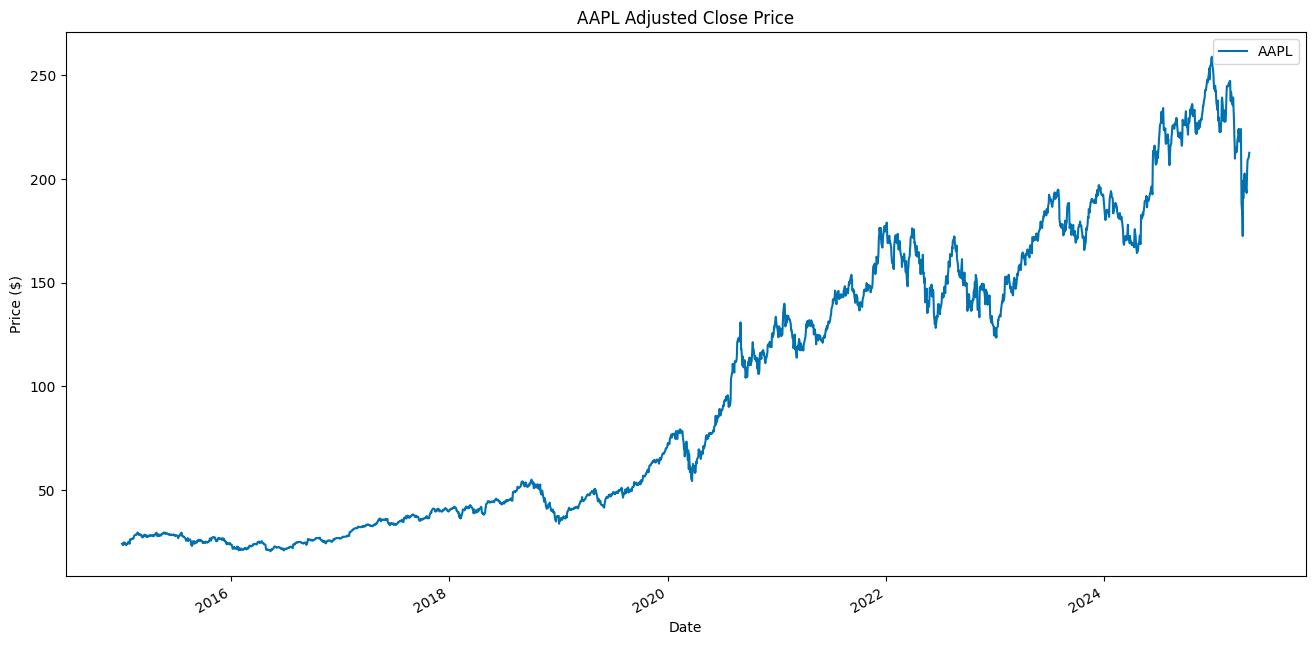

In [27]:
TICKER = "AAPL"
START_DATE = "2015-01-01"
END_DATE = "2025-04-30"
SPLIT_DATE = datetime(2025, 1, 1)

def get_adj_close_price(symbol: str, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Fetches adjusted close prices for a given ticker and date range from FMP.
    """
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}"
    params = {
        "from": start_date,
        "to": end_date,
        "apikey": FMP_API_KEY
    }
    response = requests.get(url, params=params)
    r_json = response.json()

    if "historical" not in r_json:
        raise ValueError(f"No historical data found for {symbol}")

    df = pd.DataFrame(r_json["historical"]).set_index("date").sort_index()
    df.index = pd.to_datetime(df.index)
    return df[["adjClose"]].rename(columns={"adjClose": symbol})


price_df = get_adj_close_price(TICKER, START_DATE, END_DATE)
price_df.plot(title=f"{TICKER} Adjusted Close Price", ylabel="Price ($)", xlabel="Date");


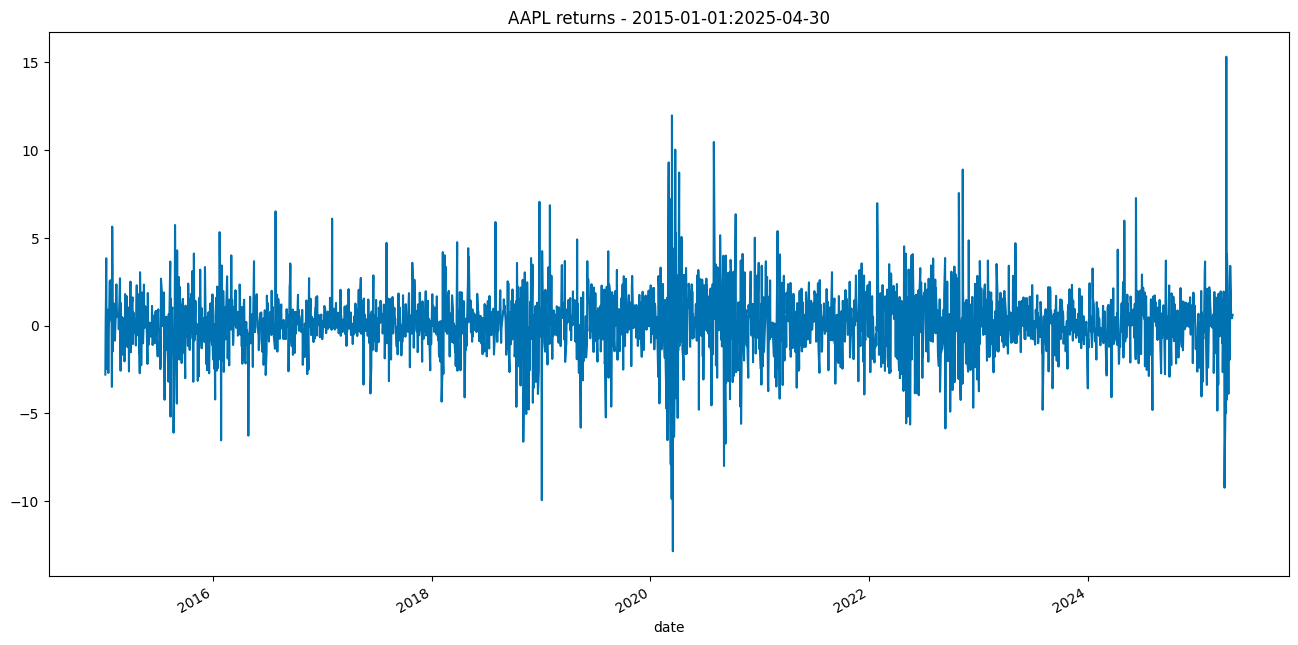

In [28]:
return_df = 100 * price_df[TICKER].pct_change().dropna()
return_df.name = "asset_returns"
return_df.plot(title=f"{TICKER} returns - {START_DATE}:{END_DATE}");

In [29]:
return_df.shape

(2596,)

## Creating a volatility forecast with ARCH

In [17]:
model_1 = arch_model(return_df, mean="Zero", vol="ARCH", p=1, q=0)
model_2 = arch_model(return_df, mean="Zero", vol="ARCH", p=5, q=0)

In [18]:
fitted_model_1 = model_1.fit(disp="off")
fitted_model_2 = model_2.fit(disp="off")


In [19]:

print(fitted_model_1.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5158.24
Distribution:                  Normal   AIC:                           10320.5
Method:            Maximum Likelihood   BIC:                           10332.2
                                        No. Observations:                 2596
Date:                Mon, May 05 2025   Df Residuals:                     2596
Time:                        13:35:15   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          2.5171      0.166     15.203  3.374e-52 [  2.193,  2.84

In [20]:

print(fitted_model_2.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5030.98
Distribution:                  Normal   AIC:                           10074.0
Method:            Maximum Likelihood   BIC:                           10109.1
                                        No. Observations:                 2596
Date:                Mon, May 05 2025   Df Residuals:                     2596
Time:                        13:35:15   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.4362      0.143     10.033  1.089e-23   [  1.15

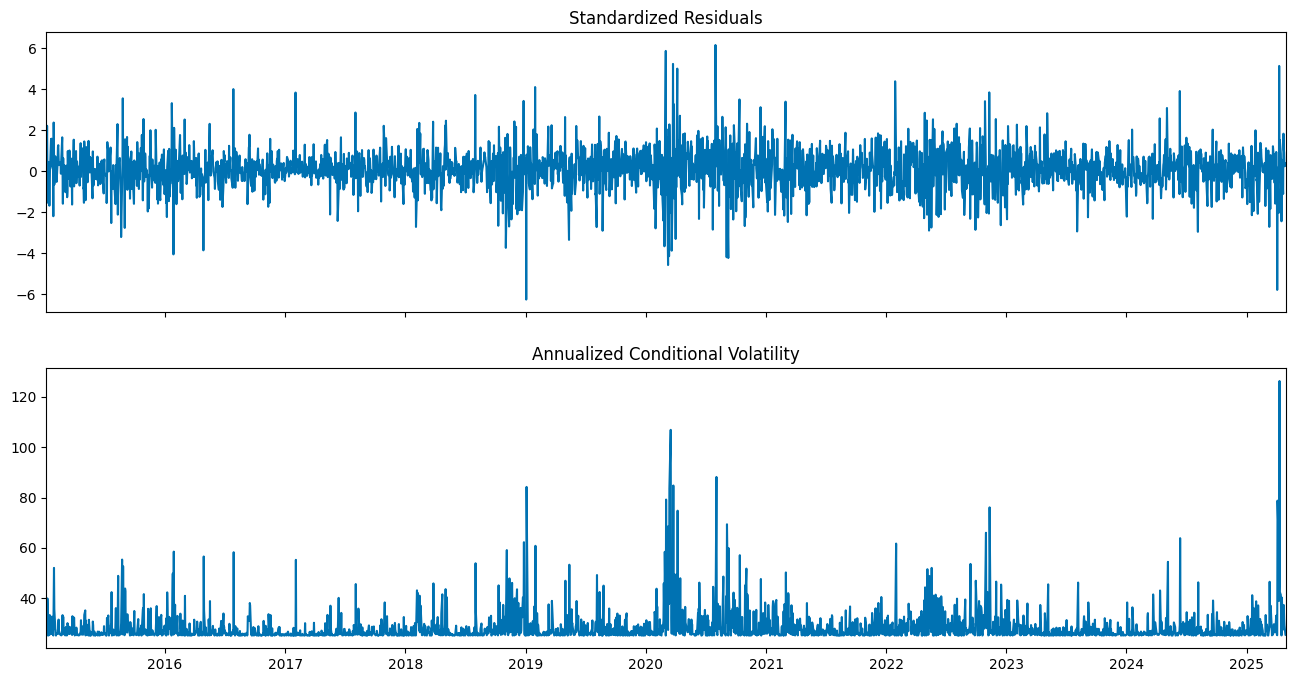

In [21]:
fitted_model_1.plot(annualize="D");

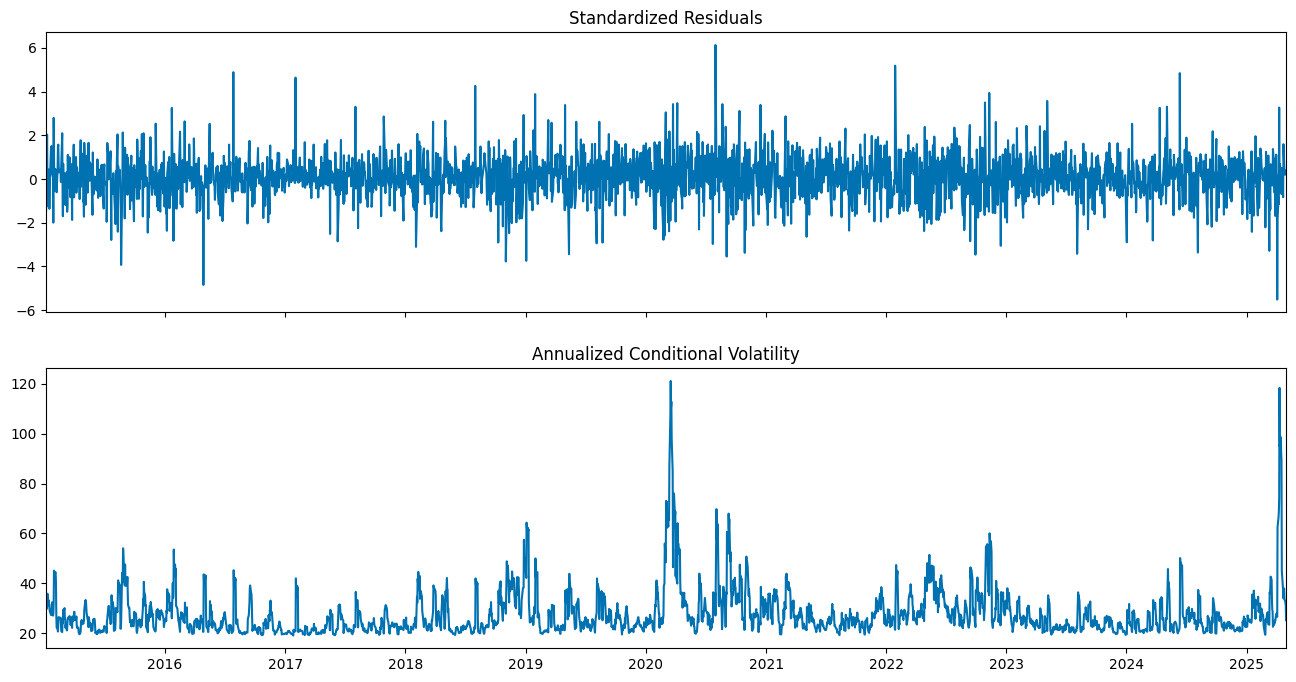

In [22]:
fitted_model_2.plot(annualize="D");

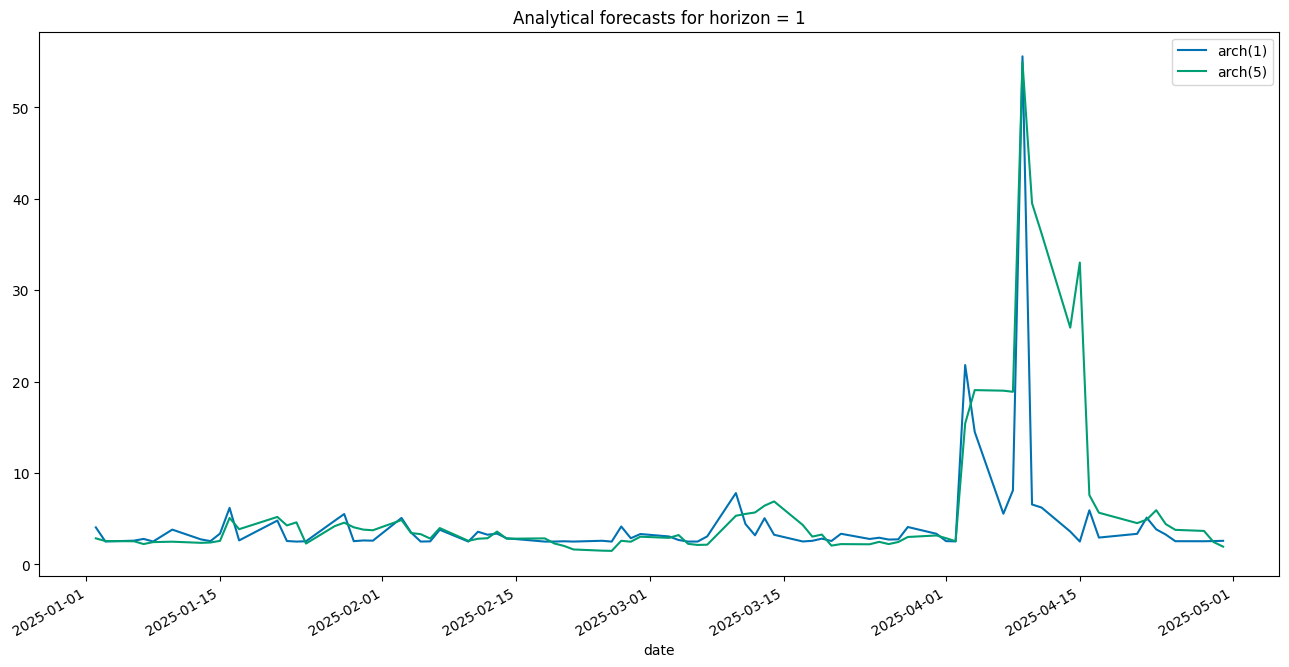

In [23]:
fitted_model_1 = model_1.fit(last_obs=SPLIT_DATE, disp="off")
fitted_model_2 = model_2.fit(last_obs=SPLIT_DATE, disp="off")

forecasts_analytical_1 = fitted_model_1.forecast(
    horizon=1,
    start=SPLIT_DATE,
    method="analytic",
    reindex=False
)

forecasts_analytical_2 = fitted_model_2.forecast(
    horizon=1,
    start=SPLIT_DATE,
    method="analytic",
    reindex=False
)

a = forecasts_analytical_1.variance.rename(columns={"h.1": "arch(1)"})
b = forecasts_analytical_2.variance.rename(columns={"h.1": "arch(5)"})
a.join(b).plot(title="Analytical forecasts for horizon = 1");